In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm, tqdm_notebook

from glob import glob

import re
import gc

import json

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import plotly.express as px #Plotly Express

from plotly.offline import iplot
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.style.use('seaborn-whitegrid')
sns.set_palette('Set3')

import os
print(os.listdir('../input/'))

import warnings
warnings.simplefilter('ignore')

from time import time, strftime, gmtime
start = time()
import datetime
print(str(datetime.datetime.now()))

['careerbuilder-job-listing-2020']
2021-05-30 01:49:24.493207


In [2]:
os.listdir('../input/careerbuilder-jobs-2020-csv/')

FileNotFoundError: [Errno 2] No such file or directory: '../input/careerbuilder-jobs-2020-csv/'

In [3]:
path = '/kaggle/input/careerbuilder-job-listing-2020/marketing_sample_for_careerbuilder_usa-careerbuilder_job_listing__20200401_20200630__30k_data.ldjson'

__Read raw ldjson file to pandas dataframe__

In [4]:
%%time
jobs = pd.DataFrame()
with open(path, 'r') as f:
    for i, line in enumerate(f):
        try:
            data = json.loads(line.strip('\n'))
            temp = pd.DataFrame([data], columns = data.keys())
            jobs = pd.concat([jobs, temp], axis = 0)
        except Exception as e:
            print(e)

Extra data: line 1 column 7004 (char 7003)
CPU times: user 38min 20s, sys: 3min 4s, total: 41min 25s
Wall time: 41min 25s


In [5]:
jobs = jobs.reset_index(drop = True)
print(jobs.shape)
jobs.to_csv('./CareerBuilder_Jobs_2020.csv', index = False)

(29982, 40)


In [6]:
#jobs = pd.read_csv('../input/careerbuilder-jobs-2020-csv/CareerBuilder_Jobs_2020.csv')
#print(jobs.shape)
#jobs.head()

In [7]:
jobs.describe().T

,count,mean,std,min,25%,50%,75%,max
fitness_score,29982.0,9.999967,0.005775,9.0,10.0,10.0,10.0,10.0


In [8]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29982 entries, 0 to 29981
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   uniq_id                       29982 non-null  object
 1   crawl_timestamp               29982 non-null  object
 2   url                           29982 non-null  object
 3   job_title                     29982 non-null  object
 4   company_name                  29982 non-null  object
 5   city                          29982 non-null  object
 6   state                         29982 non-null  object
 7   country                       29973 non-null  object
 8   post_date                     29982 non-null  object
 9   job_description               29982 non-null  object
 10  job_type                      29750 non-null  object
 11  inferred_salary_time_unit     29982 non-null  object
 12  company_description           15839 non-null  object
 13  salary_offered  

In [9]:
missing = jobs.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(jobs)) * 100
missing.index = missing['features']
del missing['features']

missing['total_missing'].iplot(kind = 'bar', 
                               title = 'Missing Values Count in Dataset',
                               xTitle = 'Features',
                               colors = 'red',
                               yTitle = 'Count')
missing.T

features,uniq_id,crawl_timestamp,url,job_title,company_name,city,state,country,post_date,job_description,...,inferred_state,inferred_country,fitness_score,inferred_salary_from,inferred_salary_to,inferred_salary_currency,is_consumed_job,job_requirements,contact_email,test_contact_email
total_missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,0.0,0.0,...,0.0,0.0,0.0,25791.000000,25791.000000,26464.000000,29767.000000,29979.000000,29970.000000,29978.000000
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030018,0.0,0.0,...,0.0,0.0,0.0,86.021613,86.021613,88.266293,99.282903,99.989994,99.959976,99.986659


- We remove the features with missing values more than 80%, imputing these missing values is of no use

In [10]:
to_drop = missing[missing['percent'] >= 80.0].index
print(f"There are {len(to_drop)} features with more than 80% missing values. We will drop this from dataset.")
jobs.drop(to_drop, axis = 1, inplace = True)
jobs.shape

There are 7 features with more than 80% missing values. We will drop this from dataset.


(29982, 33)

<code>__Job Title__</code>

Let's plot WordCloud of the Job titles offered

In [11]:
import itertools
import collections
from collections import Counter

from nltk.corpus import stopwords

import re
from wordcloud import WordCloud

def plot_wordcloud(data, col, text = None):
    stop = stopwords.words('english')
    all_words = [word for word in data[col] if word not in stop]
    word_freq = Counter(all_words)

    wordcloud = WordCloud(width = 900,
                          height = 500,
                          max_words = 200,
                          max_font_size = 100,
                          relative_scaling = 0.5,
                          background_color = "rgba(255, 255, 255, 0)", 
                          mode = "RGBA",
                          normalize_plurals = True).generate_from_frequencies(word_freq)
    plt.figure(figsize = (18, 16))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(text, fontsize = 20, color = 'Red', y = 1.05)
    plt.axis("off")
    plt.show()

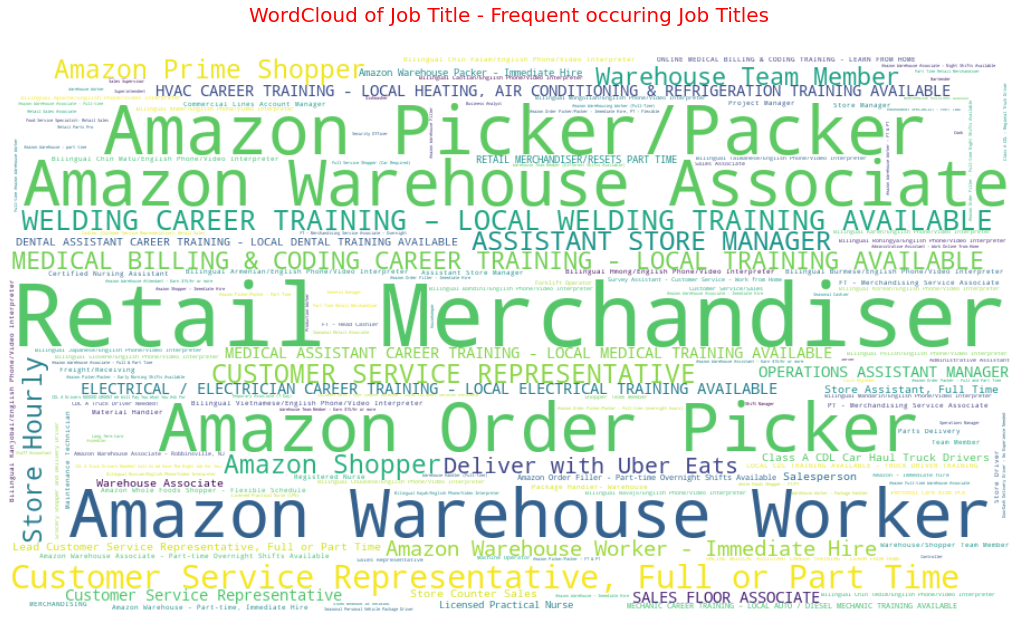

In [12]:
plot_wordcloud(jobs, 'job_title', 'WordCloud of Job Title - Frequent occuring Job Titles')

<code>__State__</code>

In [13]:
jobs['state'].value_counts().sort_values(ascending = True).iplot(kind = 'bar', 
                                                                  orientation = 'h',
                                                                  yTitle = 'States',
                                                                  title = 'States with most Job Vacancies'
                                                                 )

- CA - California has the highest job postings followed by NJ

<code>__Company_name__</code>

In [14]:
print(f"Number of companies doing Job postings: {jobs['company_name'].nunique()}")

Number of companies doing Job postings: 2679


In [15]:
jobs['company_name'].value_counts().sort_values(ascending = False)[:50].iplot(kind = 'bar', 
                                                                  orientation = 'h',
                                                                  yTitle = 'Company Names',
                                                                  colors = 'grey',
                                                                  title = 'Companies by their Vacancies'
                                                                 )

- Amazon Fulfillment has the largest number of Job postings -  7501
- The 2nd largest number of postings is by GPAC - 924

- Let's check the location of Amazon Fulfillment's Jobs

In [16]:
amazon = jobs[jobs['company_name'] == 'Amazon Fulfillment'][['state', 'city']].value_counts()
print(f"Amazon Fulfillment has job vacancies in {len(amazon)} locations")

Amazon Fulfillment has job vacancies in 2286 locations


In [17]:
amazon[:50].iplot(kind = 'bar', 
                  orientation = 'h',
                  yTitle = 'State-City',
                  title = 'Top 50 Amazon Fulfillment Jobs Location',
                  colors = 'blue'
                 )

- The above plot shows the top 50 locations of the jobs postings from Amazon Fulfillment
- Boston, MA has the highest number of vacancies
- Next comes the Cincinnati, OH

In [18]:
print(f"Number of locations with one Amazon Fulfillment job vacancies is {len(amazon[amazon.values == 1])}")

Number of locations with one Amazon Fulfillment job vacancies is 1003


In [19]:
amazon[-50:].iplot(kind = 'bar', 
                  orientation = 'h',
                  yTitle = 'State-City',
                  title = 'Bottom 50 Amazon Fulfillment Jobs Location',
                  colors = 'red'
                 )

<code>__Job_Type__</code>

In [20]:
jobtypes = jobs['job_type'].value_counts()
px.pie(jobtypes, values = jobtypes.values, names = jobtypes.index,
       title = 'No. of Job Postings by Job_Type',
      color_discrete_sequence = px.colors.qualitative.Pastel)

Check which companies have Full-Time, Part-Time Jobs

__Full-Time__

In [21]:
job_type = jobs[jobs['job_type'] == 'Full-Time'][['company_name', 'state', 'city', 'job_title']]
job_type['company_name'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Companies',
                                                  colors = 'green',
                                                  title = 'Top 10 companies offering Full-Time positions'
                                                 )

- Amazon offers most Full-Time positions follwed by GPAC and Lowe's

In [22]:
job_type[['state', 'city']].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'v',
                                                  yTitle = 'State-City',
                                                  colors = 'gold',
                                                  title = 'Top 10 Locations with Full-Time positions'
                                                 )

In [23]:
job_type['job_title'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Job Title',
                                                  colors = 'blue',
                                                  title = 'Top 10 Job Title for Full-Time Jobs'
                                                 )

__Part-Time__

In [24]:
job_type = jobs[jobs['job_type'] == 'Part-Time'][['company_name', 'state', 'city', 'job_title']]
job_type['company_name'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Companies',
                                                  colors = 'gray',
                                                  title = 'Top 10 companies offering Part-Time positions'
                                                 )

In [25]:
job_type[['state', 'city']].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'v',
                                                  yTitle = 'State-City',
                                                  colors = 'violet',
                                                  title = 'Top 10 Locations with Part-Time positions'
                                                 )

In [26]:
job_type['job_title'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Job Title',
                                                  colors = 'blue',
                                                  title = 'Top 10 Job Title for Part-Time Jobs'
                                                 )

__Contractor__

In [27]:
job_type = jobs[jobs['job_type'] == 'Contractor'][['company_name', 'state', 'city', 'job_title']]
job_type['company_name'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Companies',
                                                  colors = 'gray',
                                                  title = 'Top 10 companies offering Contractor Job Type'
                                                 )

In [28]:
job_type[['state', 'city']].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'v',
                                                  yTitle = 'State-City',
                                                  colors = 'blue',
                                                  title = 'Top 10 Locations with Contractor Job Type'
                                                 )

In [29]:
job_type['job_title'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Job Title',
                                                  colors = 'blue',
                                                  title = 'Top 10 Job Title for Contractor Jobs'
                                                 )

__Seasonal/Temp Jobs__

In [30]:
job_type = jobs[jobs['job_type'] == 'Seasonal/Temp'][['company_name', 'state', 'city', 'job_title']]
job_type['company_name'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Companies',
                                                  colors = 'red',
                                                  title = 'Top 10 companies offering Temp Jobs'
                                                 )

In [31]:
job_type[['state', 'city']].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'v',
                                                  yTitle = 'State-City',
                                                  colors = 'grey',
                                                  title = 'Top 10 Locations with Temp Jobs'
                                                 )

In [32]:
job_type['job_title'].value_counts()[:10].iplot(kind = 'bar', 
                                                  orientation = 'h',
                                                  yTitle = 'Job Title',
                                                  colors = 'blue',
                                                  title = 'Top 10 Job Title for Temp Jobs'
                                                 )

In [33]:
finish = time()
print(strftime("%H:%M:%S", gmtime(finish - start)))

00:41:46
